# **Import Packages**

In [ ]:
import os
import glob
import torch
import numpy as np
import pandas as pd
import os.path as osp
from PIL import Image
import torch.nn as nn
from numpy import mean
import torchvision as tv
from torch.utils import data
from google.colab import drive
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models

# from skimage import io
# from IPython.display import Image

torch.manual_seed(60)
%matplotlib inline

# **Dataset 1**

## **Dataset Preperation**

In [ ]:
# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded['training-a.csv']))
# df.head()

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/SCLab/Assignment2/training-a.csv')
df.head()

In [ ]:
df.drop(['original filename', 'scanid', 'database name original', 'contributing team', 'database name'], axis = 1, inplace = True)
df.to_csv('training_set.csv', index = False)
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/SCLab/Assignment2/training_set.csv')
df.shape

(19702, 2)

In [ ]:
class DigitDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform = None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path).convert('L')
        y_label = torch.tensor(int(self.annotations.iloc[index, 1]))

        if self.transform:
            image = self.transform(image)
            
        return image, y_label

## **1st Attempt**

### **DNN Model**

In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()

        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()

        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()

        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()

        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()

        self.linear_5 = nn.Linear(num_hidden, num_hidden)
        self.relu_5 = nn.ReLU()

        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()

        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)

        out  = self.linear_3(out)
        out = self.relu_3(out)

        out  = self.linear_4(out)
        out = self.relu_4(out)

        out  = self.linear_5(out)
        out = self.relu_5(out)

        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas = self.linear_out(out)
        return probas

### **Model Training**

In [ ]:
batch_size = 512
num_iters = 50000
input_dim = 180*180
num_hidden = 200
output_dim = 10
learning_rate = 0.05
# number of hidden layers = 6

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mean = 0.5
std = 0.5
custom_transform = transforms.Compose([transforms.Resize(180), transforms.ToTensor(), transforms.Normalize(mean, std)])
dataset = DigitDataset(csv_file = '/content/gdrive/MyDrive/Colab Notebooks/SCLab/Assignment2/training_set.csv',
                       root_dir = '/content/gdrive/MyDrive/Colab Notebooks/SCLab/Assignment2/training-a',
                       transform = custom_transform)

dataset_len = len(dataset)
train_len = int(dataset_len * 0.8)
test_len = dataset_len - train_len
train_set, test_set = data.random_split(dataset, [train_len, test_len])

num_epochs = num_iters / (len(train_set) / batch_size)
num_epochs = int(num_epochs)

train_loader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle = False)

print('Train loader: ', len(train_loader))
print('Test loader: ', len(test_loader))
print('Per image size: ', train_set[0][0].numpy().shape)
print('Sample label: 1st image: ', train_set[0][1])

cuda:0
Train loader:  31
Test loader:  8
Per image size:  (1, 180, 180)
Sample label: 1st image:  tensor(4)


In [ ]:
iter = 0
iter_list = []
loss_list = []

model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)
        loss_list.append(loss)

        loss.backward()

        optimizer.step()

        iter += 1
        iter_list.append(iter)

        if iter % 500 == 0:       
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.view(-1, 180*180).to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

## **2nd Attempt**

### **DNN Model**

In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()

        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()

        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()

        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()

        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()

        self.linear_5 = nn.Linear(num_hidden, num_hidden)
        self.relu_5 = nn.ReLU()

        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()

        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)

        out  = self.linear_3(out)
        out = self.relu_3(out)

        out  = self.linear_4(out)
        out = self.relu_4(out)

        out  = self.linear_5(out)
        out = self.relu_5(out)

        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas = self.linear_out(out)
        return probas

### **Model Training**

In [ ]:
batch_size = 128
num_iters = 30000
input_dim = 180*180
num_hidden = 200
output_dim = 10
learning_rate = 0.05
# num_hidden_layers = 6

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mean = 0.5
std = 0.5
custom_transform = transforms.Compose([transforms.Resize(180), transforms.ToTensor(), transforms.Normalize(mean, std)])
dataset = DigitDataset(csv_file = '/content/gdrive/MyDrive/Colab Notebooks/SCLab/Assignment2/training_set.csv',
                       root_dir = '/content/gdrive/MyDrive/Colab Notebooks/SCLab/Assignment2/training-a',
                       transform = custom_transform)

dataset_len = len(dataset)
train_len = int(dataset_len * 0.8)
test_len = dataset_len - train_len
train_set, test_set = data.random_split(dataset, [train_len, test_len])

num_epochs = num_iters / (len(train_set) / batch_size)
num_epochs = int(num_epochs)

train_loader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle = False)

print('Train loader: ', len(train_loader))
print('Test loader: ', len(test_loader))
print('Per image size: ', train_set[0][0].numpy().shape)
print('Sample label: 1st image: ', train_set[0][1])

cuda:0
Train loader:  124
Test loader:  31
Per image size:  (1, 180, 180)
Sample label: 1st image:  tensor(5)


In [ ]:
iter = 0
iter_list = []
loss_list = []

model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)
        loss_list.append(loss)

        loss.backward()

        optimizer.step()

        iter += 1
        iter_list.append(iter)

        if iter % 500 == 0:       
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.view(-1, 180*180).to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

## **3rd Attempt**

### **DNN Model**

In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()

        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()

        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()

        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()

        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()

        self.linear_5 = nn.Linear(num_hidden, num_hidden)
        self.relu_5 = nn.ReLU()

        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()

        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)

        out  = self.linear_3(out)
        out = self.relu_3(out)

        out  = self.linear_4(out)
        out = self.relu_4(out)

        out  = self.linear_5(out)
        out = self.relu_5(out)

        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas = self.linear_out(out)
        return probas

### **Model Training**

In [ ]:
batch_size = 128
num_iters = 55000
input_dim = 180*180
num_hidden = 200
output_dim = 10
learning_rate = 0.06
# num_hidden_layers = 6

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mean = 0.5
std = 0.5
custom_transform = transforms.Compose([transforms.Resize(180), transforms.ToTensor(), transforms.Normalize(mean, std)])
dataset = DigitDataset(csv_file = '/content/gdrive/MyDrive/Colab Notebooks/SCLab/Assignment2/training_set.csv',
                       root_dir = '/content/gdrive/MyDrive/Colab Notebooks/SCLab/Assignment2/training-a',
                       transform = custom_transform)

dataset_len = len(dataset)
train_len = int(dataset_len * 0.8)
test_len = dataset_len - train_len
train_set, test_set = data.random_split(dataset, [train_len, test_len])

num_epochs = num_iters / (len(train_set) / batch_size)
num_epochs = int(num_epochs)

train_loader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle = False)

print('Train loader: ', len(train_loader))
print('Test loader: ', len(test_loader))
print('Per image size: ', train_set[0][0].numpy().shape)
print('Sample label: 1st image: ', train_set[0][1])

cuda:0
Train loader:  124
Test loader:  31
Per image size:  (1, 180, 180)
Sample label: 1st image:  tensor(5)


In [ ]:
iter = 0
iter_list = []
loss_list = []

model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)
        loss_list.append(loss)

        loss.backward()

        optimizer.step()

        iter += 1
        iter_list.append(iter)

        if iter % 500 == 0:       
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.view(-1, 180*180).to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.299192190170288. Accuracy: 10.175082466379092
Iteration: 1000. Loss: 2.2512331008911133. Accuracy: 14.8439482364882
Iteration: 1500. Loss: 2.148746967315674. Accuracy: 20.502410555696525
Iteration: 2000. Loss: 2.1476471424102783. Accuracy: 19.538188277087034
Iteration: 2500. Loss: 2.1747748851776123. Accuracy: 18.32022329358031
Iteration: 3000. Loss: 1.8908371925354004. Accuracy: 14.260340015224562
Iteration: 3500. Loss: 1.999036192893982. Accuracy: 33.95077391524994
Iteration: 4000. Loss: 2.179858446121216. Accuracy: 23.369703121035272
Iteration: 4500. Loss: 1.8531984090805054. Accuracy: 31.51484394823649
Iteration: 5000. Loss: 1.7889331579208374. Accuracy: 31.489469677746765
Iteration: 5500. Loss: 1.7536343336105347. Accuracy: 41.309312357269725
Iteration: 6000. Loss: 1.841538429260254. Accuracy: 24.99365643237757
Iteration: 6500. Loss: 1.7651256322860718. Accuracy: 24.53691956356255
Iteration: 7000. Loss: 2.0274102687835693. Accuracy: 35.244861710225834
Itera

### **Loss Curve**

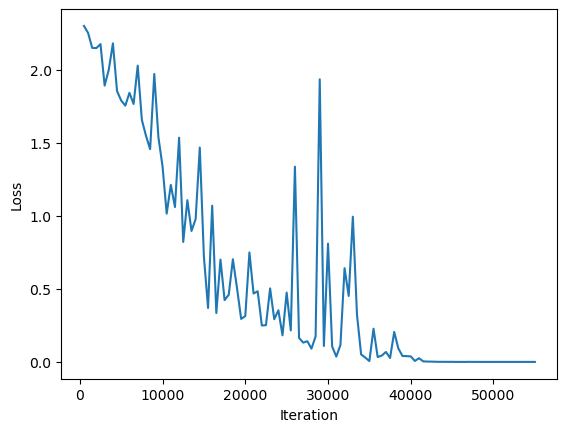

In [ ]:
plt.plot(iter_list, loss_list)
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.savefig('loss_ex2.png')
plt.show()

## **4th Attempt**

### **DNN Model**

In [ ]:
class DeepNeuralNetworkModel(nn.Module):
    def __init__(self, input_size, num_classes, num_hidden):
        super().__init__()

        self.linear_1 = nn.Linear(input_size, num_hidden)
        self.relu_1 = nn.ReLU()

        self.linear_2 = nn.Linear(num_hidden, num_hidden)
        self.relu_2 = nn.ReLU()

        self.linear_3 = nn.Linear(num_hidden, num_hidden)
        self.relu_3 = nn.ReLU()

        self.linear_4 = nn.Linear(num_hidden, num_hidden)
        self.relu_4 = nn.ReLU()

        self.linear_5 = nn.Linear(num_hidden, num_hidden)
        self.relu_5 = nn.ReLU()

        self.linear_6 = nn.Linear(num_hidden, num_hidden)
        self.relu_6 = nn.ReLU()

        self.linear_out = nn.Linear(num_hidden, num_classes)

    def forward(self, x):
        out  = self.linear_1(x)
        out = self.relu_1(out)
        
        out  = self.linear_2(out)
        out = self.relu_2(out)

        out  = self.linear_3(out)
        out = self.relu_3(out)

        out  = self.linear_4(out)
        out = self.relu_4(out)

        out  = self.linear_5(out)
        out = self.relu_5(out)

        out  = self.linear_6(out)
        out = self.relu_6(out)
        
        probas = self.linear_out(out)
        return probas

### **Model Training**

In [ ]:
batch_size = 128
num_iters = 55000
input_dim = 180*180
num_hidden = 200
output_dim = 10
learning_rate = 0.06
# num_hidden_layers = 6

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mean = 0.5
std = 0.5
custom_transform = transforms.Compose([transforms.Resize(180), transforms.ToTensor(), transforms.Normalize(mean, std)])
dataset = DigitDataset(csv_file = '/content/gdrive/MyDrive/Colab Notebooks/SCLab/Assignment2/training_set.csv',
                       root_dir = '/content/gdrive/MyDrive/Colab Notebooks/SCLab/Assignment2/training-a',
                       transform = custom_transform)

dataset_len = len(dataset)
train_len = int(dataset_len * 0.8)
test_len = dataset_len - train_len
train_set, test_set = data.random_split(dataset, [train_len, test_len])

num_epochs = num_iters / (len(train_set) / batch_size)
num_epochs = int(num_epochs)

train_loader = DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(dataset = test_set, batch_size = batch_size, shuffle = False)

print('Train loader: ', len(train_loader))
print('Test loader: ', len(test_loader))
print('Per image size: ', train_set[0][0].numpy().shape)
print('Sample label: 1st image: ', train_set[0][1])

cuda:0
Train loader:  124
Test loader:  31
Per image size:  (1, 180, 180)
Sample label: 1st image:  tensor(7)


In [ ]:
iter = 0
iter_list = []
loss_list = []

model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adagrad(model.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 180*180).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)
        loss_list.append(loss)

        loss.backward()

        optimizer.step()

        iter += 1
        iter_list.append(iter)

        if iter % 500 == 0:       
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.view(-1, 180*180).to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

# **Dataset 2**

## **Model Training**

In [ ]:
batch_size = 128
num_iters = 55000
input_dim = 28*28
num_hidden = 200
output_dim = 10
learning_rate = 0.06
# num_hidden_layers = 6

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

train_set = datasets.FashionMNIST(root = './data', train = True, transform = transforms.ToTensor(), download = True)
test_set = datasets.FashionMNIST(root = './data', train = False, transform = transforms.ToTensor())

num_epochs = num_iters / (len(train_set) / batch_size)
num_epochs = int(num_epochs)

train_loader = torch.utils.data.DataLoader(dataset = train_set, batch_size = batch_size, shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_set, batch_size = batch_size, shuffle = False)

print('Train loader: ', len(train_loader))
print('Test loader: ', len(test_loader))
print('Per image size: ', train_set[0][0].numpy().shape)
print('Sample label: 1st image: ', train_set[0][1])

cuda:0
Train loader:  469
Test loader:  79
Per image size:  (1, 28, 28)
Sample label: 1st image:  9


C:\Users\faisa\Dev\Tools\anaconda3\envs\PyTorch190\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
iter = 0
iter_list = []
loss_list = []

model = DeepNeuralNetworkModel(input_size = input_dim, num_classes = output_dim, num_hidden = num_hidden)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 28*28).to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)
        loss_list.append(loss)

        loss.backward()

        optimizer.step()

        iter += 1
        iter_list.append(iter)

        if iter % 500 == 0:       
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.view(-1, 28*28).to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)

                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum() 
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct.item() / total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

C:\Users\faisa\Dev\Tools\anaconda3\envs\PyTorch190\lib\site-packages\torch\cuda\__init__.py:83: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))


Iteration: 500. Loss: 2.08339786529541. Accuracy: 28.92
Iteration: 1000. Loss: 0.706753134727478. Accuracy: 65.96
Iteration: 1500. Loss: 0.8534146547317505. Accuracy: 72.21
Iteration: 2000. Loss: 0.5467010140419006. Accuracy: 77.32
Iteration: 2500. Loss: 0.5233997106552124. Accuracy: 78.52
Iteration: 3000. Loss: 0.457288533449173. Accuracy: 80.35
Iteration: 3500. Loss: 0.35655543208122253. Accuracy: 83.21
Iteration: 4000. Loss: 0.326790452003479. Accuracy: 85.13
Iteration: 4500. Loss: 0.338297575712204. Accuracy: 85.06
Iteration: 5000. Loss: 0.35065141320228577. Accuracy: 85.03
Iteration: 5500. Loss: 0.406953364610672. Accuracy: 86.6
Iteration: 6000. Loss: 0.32879137992858887. Accuracy: 86.47
Iteration: 6500. Loss: 0.2508682608604431. Accuracy: 87.26
Iteration: 7000. Loss: 0.2871995270252228. Accuracy: 86.54
Iteration: 7500. Loss: 0.2989155352115631. Accuracy: 86.8
Iteration: 8000. Loss: 0.2504273056983948. Accuracy: 87.37
Iteration: 8500. Loss: 0.23037518560886383. Accuracy: 87.6
Iter

### **Save Model**

In [ ]:
root_path = '/content/gdrive/MyDrive/Colab Notebooks/SCLab/Assignment2/'
save_model = True

if save_model is True:
    torch.save(model.state_dict(), root_path + 'digit_classifier_dnn_exp1_1.pkl') 

### **Load Model**

In [ ]:
load_model = True

if load_model is True:
    model.load_state_dict(torch.load(root_path + 'digit_classifier_dnn_exp1_1.pkl'))

## **Loss Curve**

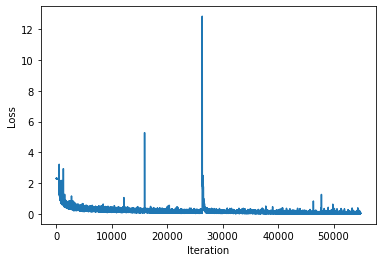

In [ ]:
perf = []
for i in range(len(iter_list)):
    perf.append([iter_list[i], loss_list[i].item()])
perf
plt.plot([i[0] for i in perf], [i[1] for i in perf])
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.savefig('loss_ex1_1.png')
plt.show()